In [7]:
import os
import pandas as pd
import numpy as np
import ast


# -------------------------------
# HELPER: parse list-like strings
# -------------------------------

def parse_list(s):
    """Convert string like '[0.2, 0.1, 0.05]' into list of floats."""
    if isinstance(s, list):
        return s
    return ast.literal_eval(s)


# -------------------------------
# METRIC EXTRACTION LOGIC

def aggregate_performance(csv_path):
    df = pd.read_csv(csv_path)

    df["iou_flat"] = df["evaluation/max_IoU_to_flattened"].apply(parse_list)
    df["nc"] = df["evaluation/normalised_coverage"].apply(parse_list)
    df["ni"] = df["evaluation/normalised_improvement"].apply(parse_list)
    df["success_list"] = df["evaluation/success"].apply(parse_list)

    # ---------------------------
    # Extract per-row statistics
    # ---------------------------


    max_nc = [np.max(x) for x in df["nc"]]
    last_nc = [x[-1] for x in df["nc"]]
    max_ni = [np.max(x) for x in df["ni"]]
    last_ni = [x[-1] for x in df["ni"]]

    last_max_iou = [x[-1] for x in df["iou_flat"]]
    max_max_iou = [np.max(x) for x in df["iou_flat"]]

    # ---------------------------
    # Success + steps-to-finish
    # ---------------------------

    first_success_flags = []
    final_success_flags = []
    steps_to_first_success = []

    for success_list in df["success_list"]:
        if any(success_list):
            first_success_flags.append(1)
            steps_to_first_success.append(success_list.index(True))
        else:
            first_success_flags.append(0)
            steps_to_first_success.append(len(success_list) - 1)
        if success_list[-1]:
            final_success_flags.append(1)
        else:
            final_success_flags.append(0)

    # ---------------------------
    # Aggregated metrics (means)
    # ---------------------------


    max_iou_mean = np.mean(max_max_iou)
    #max_iou_flat_mean = np.mean(max_iou_flat)
    last_iou_mean = np.mean(last_max_iou)
    max_nc_mean = np.mean(max_nc)
    max_ni_mean = np.mean(max_ni)
    last_nc_mean = np.mean(max_nc)
    last_ni_mean = np.mean(max_ni)

    first_success_rate = np.mean(first_success_flags)
    final_success_rate = np.mean(final_success_flags)
    print('final_success_flags', final_success_flags)

    # ---------------------------
    # Standard deviations
    # ---------------------------
    #max_iou_flat_std = np.std(max_iou_flat)

    max_iou_std = np.std(max_max_iou)
    last_iou_std = np.std(last_max_iou)

    max_nc_std = np.std(max_nc)
    max_ni_std = np.std(max_ni)

    last_nc_std = np.mean(last_nc)
    last_ni_std = np.mean(last_ni)

    # ---------------------------
    # Episode counts
    # ---------------------------

    num_episodes = len(df)
    first_success_episodes = int(np.sum(first_success_flags))
    final_success_episodes = int(np.sum(final_success_flags))
    steps_to_finish_mean = np.mean(steps_to_first_success)
    steps_to_finish_std = np.std(steps_to_first_success)

    return {
        # Means

        "max_IoU_mean": max_iou_mean,
        #"max_IoU_to_flattened_mean": max_iou_flat_mean,
        "max_NC_mean": max_nc_mean, 
        "max_NI_std": max_ni_mean,
        "last_IoU_mean": last_iou_mean,
        "last_NC_mean": last_nc_mean,
        "last_NI_mean": last_ni_mean,
        "steps_to_first_success_mean": steps_to_finish_mean,

        # Standard deviations
        "max_IoU_std": max_iou_std,
        "last_IoU_std": last_iou_std,
        "last_NC_std": last_nc_std,
        "last_NI_std": last_ni_std,
        #"max_IoU_to_flattened_std": max_iou_flat_std,
        "steps_to_first_success_std": steps_to_finish_std,
        "max_NC_std": max_nc_std, 
        "max_NI_std": max_ni_std, 

        # Others
        "first_success_rate": first_success_rate,
        "final_success_rate": final_success_rate,
        "num_episodes": num_episodes,
        "first_success_episodes": first_success_episodes,
        "final_success_episodes": final_success_episodes
    }

In [8]:
# We evaluate the ability to flattening, ablilty to folding and ability to recover from failed folding states.
# first success in a trajectory --> ability to folding
# final step success in a trajectory --> ability to recognise success and recover from failures.

data_dir = "/media/hcv530/T7/garment_folding_data"
experiments = [
    {
        "name": "diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_50",
        "label": "Diffusion-Demo-50",
        "check": "eval_checkpoint_50000"
    },
    {
        "name": "diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_100",
        "label": "Diffusion-Demo-100",
        "check": "eval_checkpoint_-2"
    },

    {
        "name": "lagarnet_single_picker_single_primitive_multi_longsleeve_flattening_sanity_check",
        "label": "All Garment LaGarNet\nfrom 50-demo Diffusion",
        "check": "eval_checkpoint_-2"
    }, 
]

rows = []

for exp in experiments:
    csv_path = os.path.join(
        data_dir,
        exp["name"],
        exp["check"],
        "performance.csv"
    )
    print('csv', csv_path)
    if not os.path.exists(csv_path):
        print(f"WARNING: Missing file: {csv_path}")
        continue
    

    metrics = aggregate_performance(csv_path)
    metrics["experiment"] = exp["label"]
    rows.append(metrics)

results_df = pd.DataFrame(rows)
cols = ["experiment"] + [c for c in results_df.columns if c != "experiment"]
results_df = results_df[cols]
display(results_df)

csv /media/hcv530/T7/garment_folding_data/diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_50/eval_checkpoint_50000/performance.csv
final_success_flags [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
csv /media/hcv530/T7/garment_folding_data/diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_100/eval_checkpoint_-2/performance.csv
final_success_flags [0]
csv /media/hcv530/T7/garment_folding_data/lagarnet_single_picker_single_primitive_multi_longsleeve_flattening_sanity_check/eval_checkpoint_-2/performance.csv
final_success_flags [0, 0]


,experiment,max_IoU_mean,max_NC_mean,max_NI_std,last_IoU_mean,last_NC_mean,last_NI_mean,steps_to_first_success_mean,max_IoU_std,last_IoU_std,last_NC_std,last_NI_std,steps_to_first_success_std,max_NC_std,first_success_rate,final_success_rate,num_episodes,first_success_episodes,final_success_episodes
0,Diffusion-Demo-50,0.731047,0.873147,0.218219,0.682643,0.873147,0.715167,19.066667,0.086508,0.114829,0.818327,0.600307,2.682453,0.090415,0.166667,0.166667,30,5,5
1,Diffusion-Demo-100,0.655400,0.897600,0.000000,0.629600,0.897600,0.839500,20.000000,0.000000,0.000000,0.857200,0.778100,0.000000,0.000000,0.000000,0.000000,1,0,0
2,All Garment LaGarNet\nfrom 50-demo Diffusion,0.798450,1.000000,0.000000,0.609150,1.000000,1.000000,20.000000,0.007050,0.051850,0.907400,0.837500,0.000000,0.000000,0.000000,0.000000,2,0,0


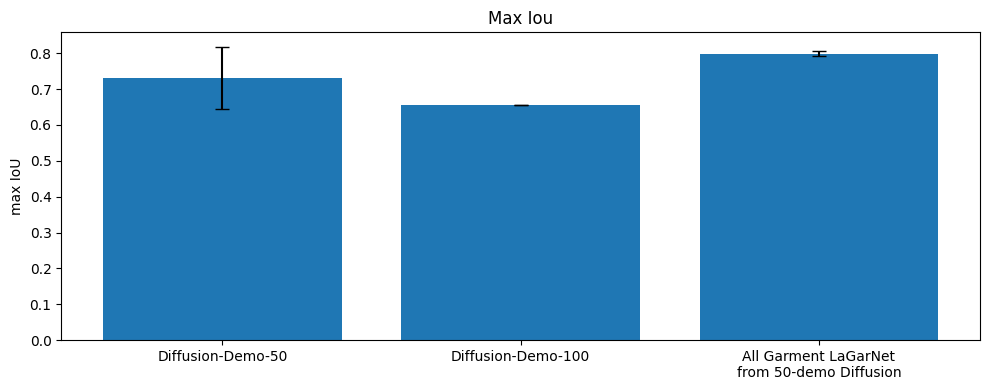

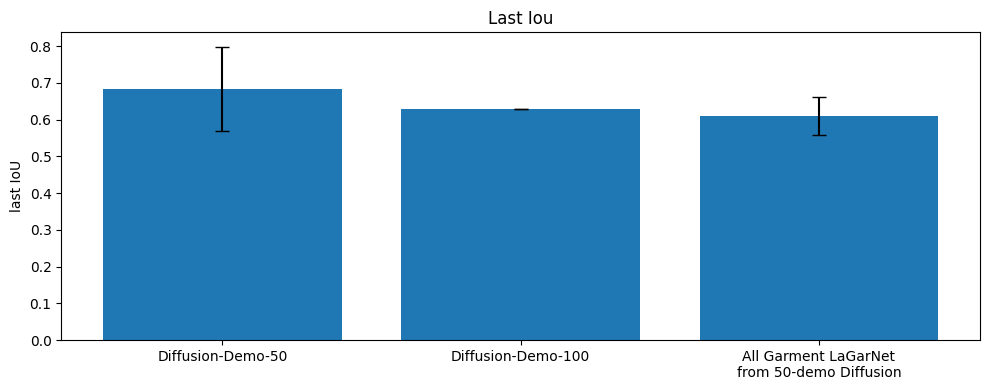

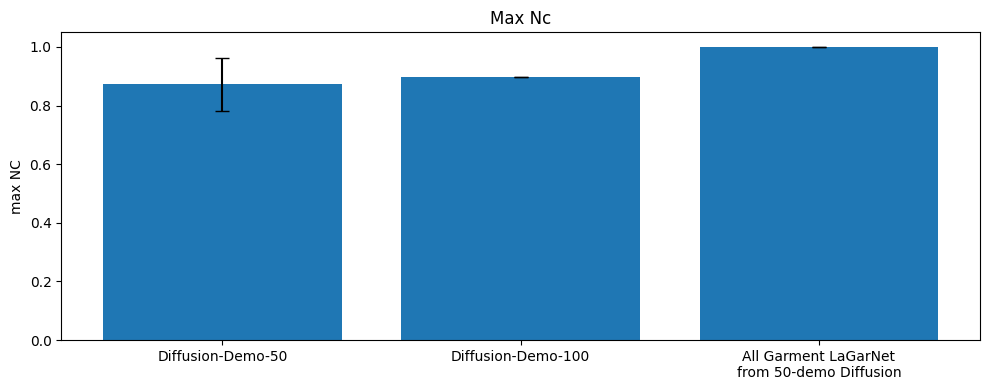

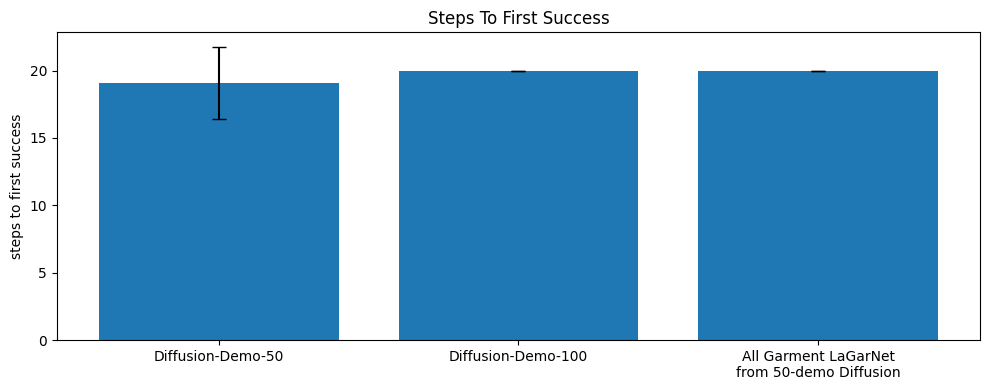

In [9]:
import matplotlib
# matplotlib.use("Agg")  # non-interactive, stable

import matplotlib.pyplot as plt

import numpy as np

# List of metrics you want to plot (base names without _mean / _std)
metrics = [
    "max_IoU",
    "last_IoU",
    "max_NC",
    "steps_to_first_success",
]

experiments = results_df["experiment"]

for metric in metrics:
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"

    means = results_df[mean_col]
    stds = results_df[std_col]

    x = np.arange(len(experiments))

    plt.figure(figsize=(10, 4))
    plt.bar(x, means, yerr=stds, capsize=5)
    plt.xticks(x, experiments)
    plt.ylabel(metric.replace("_", " "))
    plt.title(f"{metric.replace('_', ' ').title()}")

    plt.tight_layout()
    plt.show()


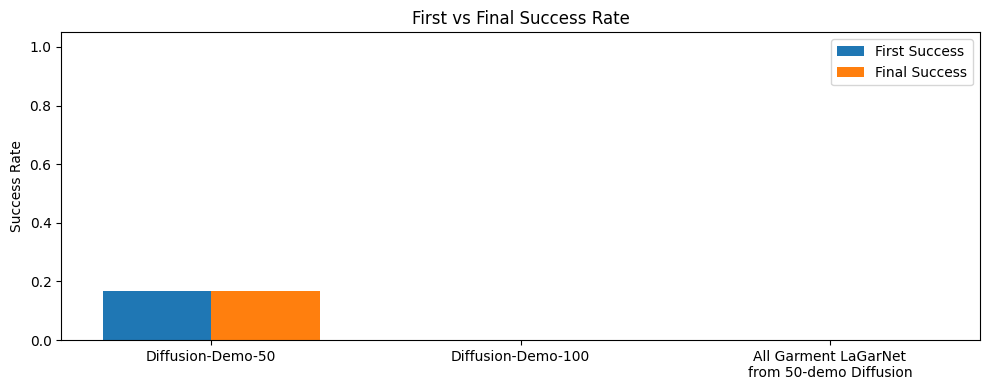

In [10]:
import matplotlib.pyplot as plt
import numpy as np

experiments = results_df["experiment"]
num_episodes = results_df["num_episodes"]

# Success rates
first_success = results_df["first_success_rate"]
final_success = results_df["final_success_rate"]

x = np.arange(len(experiments))
bar_width = 0.35

plt.figure(figsize=(10, 4))

plt.bar(
    x - bar_width / 2,
    first_success,
    bar_width,
    capsize=5,
    label="First Success",
)

plt.bar(
    x + bar_width / 2,
    final_success,
    bar_width,
    capsize=5,
    label="Final Success",
)

plt.xticks(x, experiments)
plt.ylabel("Success Rate")
plt.ylim(0, 1.05)
plt.legend()
plt.title("First vs Final Success Rate")

plt.tight_layout()
plt.show()


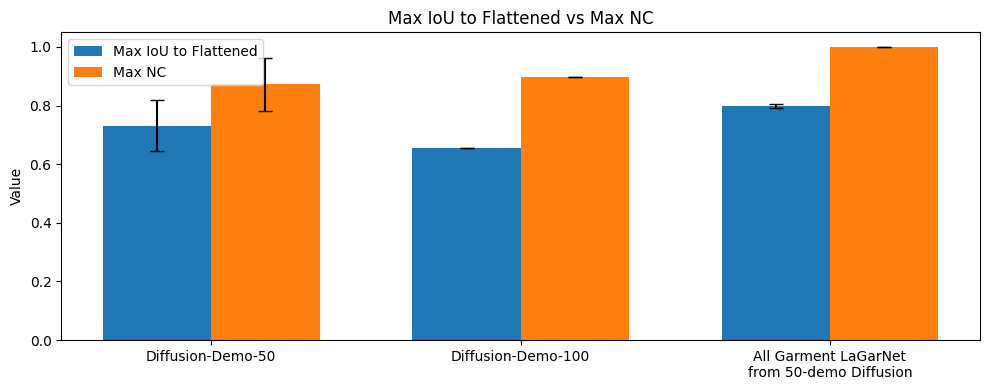

In [11]:
import matplotlib.pyplot as plt
import numpy as np

experiments = results_df["experiment"]
num_episodes = results_df["num_episodes"]

# Metrics
max_iou_flat = results_df["max_IoU_mean"]
max_nc = results_df["max_NC_mean"]

# Standard error
max_iou_flat_se = results_df["max_IoU_std"]
max_nc_se = results_df["max_NC_std"]

x = np.arange(len(experiments))
bar_width = 0.35

plt.figure(figsize=(10, 4))

plt.bar(
    x - bar_width/2,
    max_iou_flat,
    bar_width,
    yerr=max_iou_flat_se,
    capsize=5,
    label="Max IoU to Flattened",
)

plt.bar(
    x + bar_width/2,
    max_nc,
    bar_width,
    yerr=max_nc_se,
    capsize=5,
    label="Max NC",
)

plt.xticks(x, experiments)
plt.ylabel("Value")
plt.ylim(0, 1.05)
plt.title("Max IoU to Flattened vs Max NC")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# Define the metrics and whether they have a std column
metrics = [
    ("steps_to_first_success", True),  # has _mean and _std
    ("first_success_rate", False),     # no _mean, no _std
    ("final_success_rate", False),     # no _mean, no _std
    ("last_IoU", True),
    ("max_NC", True),
    ("max_IoU", True),
]

# Column labels for LaTeX
column_labels = [
    "S2F(\#)",
    "1st-SR (\%)",
    "Final-SR (\%)",
    "LM-IoU (Fold, \%)",
    "Max NC (\%)",
    "MM-IoU (Flat, \%)",
]

# Metrics to scale by 100
scale_100 = ["first_success_rate", "final_success_rate", 
             "last_IoU", "max_NC", "max_IoU"]

# Start LaTeX table
latex_table = "\\begin{tabular}{l" + "c"*len(metrics) + "}\n"
latex_table += "Experiment & " + " & ".join(column_labels) + " \\\\\n"
latex_table += "\\hline\n"

for idx, row in results_df.iterrows():
    row_values = []
    for metric, has_std in metrics:
        factor = 100 if metric in scale_100 else 1
        if has_std and f"{metric}_mean" in results_df.columns:
            mean_val = row[f"{metric}_mean"] * factor
            std_val = row[f"{metric}_std"] * factor
            row_values.append(f"${mean_val:.1f} \\pm {std_val:.1f}$")
        else:
            val = row[metric] * factor
            row_values.append(f"{val:.1f}")
    latex_table += f"{row['experiment']} & " + " & ".join(row_values) + " \\\\\n"

latex_table += "\\end{tabular}"

print(latex_table)


\begin{tabular}{lcccccc}
Experiment & S2F(\#) & 1st-SR (\%) & Final-SR (\%) & LM-IoU (Fold, \%) & Max NC (\%) & MM-IoU (Flat, \%) \\
\hline
Diffusion-Demo-50 & $19.1 \pm 2.7$ & 16.7 & 16.7 & $68.3 \pm 11.5$ & $87.3 \pm 9.0$ & $73.1 \pm 8.7$ \\
Diffusion-Demo-100 & $20.0 \pm 0.0$ & 0.0 & 0.0 & $63.0 \pm 0.0$ & $89.8 \pm 0.0$ & $65.5 \pm 0.0$ \\
All Garment LaGarNet
from 50-demo Diffusion & $20.0 \pm 0.0$ & 0.0 & 0.0 & $60.9 \pm 5.2$ & $100.0 \pm 0.0$ & $79.8 \pm 0.7$ \\
\end{tabular}
